# Baseline PINN Re 400 Nc 10000


In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.contour as contour
import pandas as pd
import scipy
import sklearn
import scipy.optimize as opt
import time
import pandas as pd

from tensorflow import keras
from pyDOE import lhs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

seed = 1232 

os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Acquired from Ansys Fluent

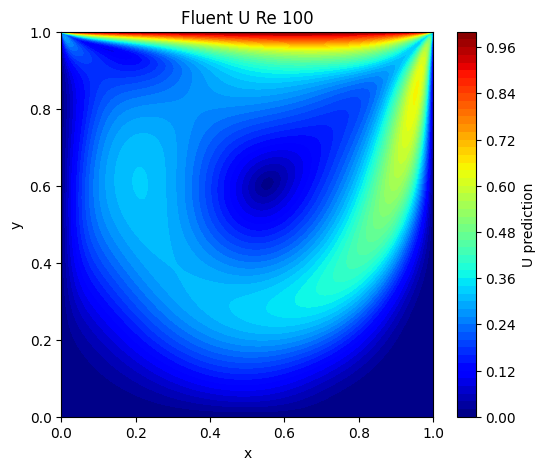

In [2]:
U_ansys = pd.read_excel("savedata 400/U_ansys Re 400.xlsx")

x_true = np.linspace(0,1,252)
y_true = np.linspace(0,1,252)
uvmag_true = np.array(U_ansys['magnitude'])/4
umag_true = np.array(U_ansys['x-velocity'])/4


X_true,Y_true = np.meshgrid(x_true,y_true)
Umag_true = umag_true.reshape(X_true.shape)
UVmag_true = uvmag_true.reshape(X_true.shape)

#nondimensionalized
UVmag_true = UVmag_true

# === Plot ===
plt.figure(figsize=(6,5))
plt.contourf(X_true, Y_true, UVmag_true, levels=50, cmap="jet")
plt.colorbar(label="U prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Fluent U Re 100")
plt.show()
plt.show()

## Validation Data

In [3]:
# create the data for validation
a,b = 0,1   #x lower and upper bound   
c,d = 0,1   #y lower and upper bound
shape = 10000 

#x data
x = np.linspace(a, b, shape, endpoint=False)
x = tf.Variable(x,dtype=tf.float32)
x = tf.reshape(x, ([tf.shape(x)[0],1]))

#y data
y = np.linspace(c, d, shape, endpoint=False)     
y = tf.Variable(y, dtype=tf.float32)
y = tf.reshape(y, (tf.shape(y)[0],1))

#create for testing after training
X,Y = np.meshgrid(x,y)
xy_test = np.hstack((X.flatten()[:,None],Y.flatten()[:,None]))

#set params
ub = 1
Re = 400

print(f'Reynolds Number: {Re}')

Reynolds Number: 400


## Training Data

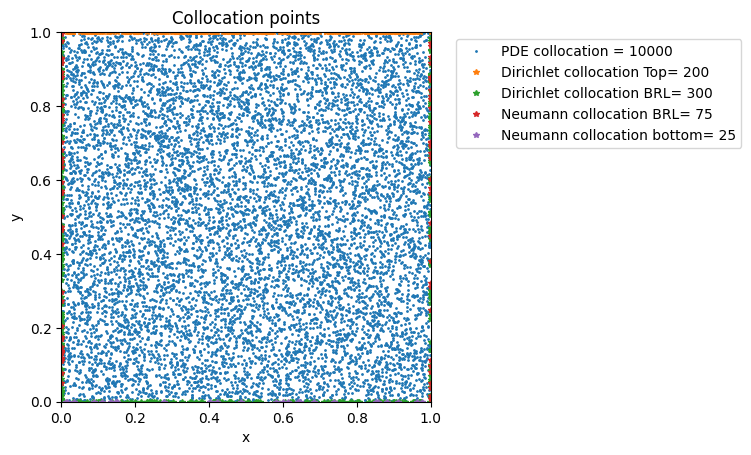

In [4]:
"""Set the Neumann"""
#set the colloc points
lower = xy_test[0]
upper = xy_test[-1]
xy_train = lower + (upper-lower)*lhs(2,10000) #insert this on input


"""Set the dirichlet"""
#set the dirichlet
U = np.zeros([shape,shape])
U[0,:] = ub
V = np.zeros([shape,shape])
P = np.zeros([shape,shape])

#top dirichlet x,y -> u,v,p
u_top_boundary = U[0,:][:,None]
v_top_boundary = V[0,:][:,None]
p_top_boundary = P[0,:][:,None]
#set the domain x,y
xy_up_top_boundary = np.hstack((X[-1][:,None], Y[-1][:,None]))

#create random form index dirichlet top
index_dirtop = np.random.choice(u_top_boundary.shape[0],200, replace=False)
u_top_boundary = u_top_boundary[index_dirtop,:]
v_top_boundary = v_top_boundary[index_dirtop,:]
p_top_boundary = p_top_boundary[index_dirtop,:]
xy_up_top_boundary = xy_up_top_boundary[index_dirtop,:] #insert this on input


#dirichlet bottom left right x,y -> u,v
u_bottom_boundary = U[-1][:,None]
v_bottom_boundary = V[-1][:,None]
xy_u_bottom_boundary = np.hstack((X[0].flatten()[:,None],Y[0].flatten()[:,None]))

u_right_boundary = U[:,-1][:,None][::-1]
v_right_boundary = V[:,-1][:,None][::-1]
xy_u_right_boundary = np.hstack((X[:,-1].flatten()[:,None],Y[:,-1].flatten()[:,None]))

u_left_boundary = U[:,0][:,None][::-1]
v_left_boundary = V[:,0][:,None][::-1]
xy_u_left_boundary = np.hstack((X[:,0].flatten()[:,None],Y[:,0].flatten()[:,None]))

#create random form index for bottom left right
u_brl_boundary = np.vstack((u_bottom_boundary,u_right_boundary,u_left_boundary))
v_brl_boundary = np.vstack((v_bottom_boundary,v_right_boundary,v_left_boundary))
index_dirbrl = np.random.choice(u_brl_boundary.shape[0],300, replace=False)

#set the domain x,y
xy_u_brl_boundary = np.vstack((xy_u_bottom_boundary,xy_u_right_boundary,xy_u_left_boundary))

u_brl_boundary = u_brl_boundary[index_dirbrl,:]
v_brl_boundary = v_brl_boundary[index_dirbrl,:]
xy_u_brl_boundary = xy_u_brl_boundary[index_dirbrl,:]   #insert this on input


"""Set the Neumann"""
#set for neumann dp = 0
dp = np.zeros([shape,shape])
dp_dx_left_boundary = dp[:,0][:,None]
dp_dx_right_boundary = dp[:,-1][:,None]
dp_dx_rl_boundary = np.vstack((dp_dx_right_boundary,dp_dx_left_boundary))
dp_dy_bottom_boundary = dp[-1][:,None]

#set the domain x,y
xy_dp_rl_boundary = np.vstack((xy_u_right_boundary,xy_u_left_boundary))
xy_dp_bottom_boundary = xy_u_bottom_boundary

#index left right
index_neu_rl = np.random.choice(dp_dx_rl_boundary.shape[0], 75, replace=False)
dp_dx_rl_boundary = dp_dx_rl_boundary[index_neu_rl,:]
xy_dp_rl_boundary = xy_dp_rl_boundary[index_neu_rl,:] #insert this on input

#index bottom
index_neubot = np.random.choice(dp_dy_bottom_boundary.shape[0], 25, replace=False)
dp_dy_bottom_boundary = dp_dy_bottom_boundary[index_neubot,:]
xy_dp_bottom_boundary = xy_dp_bottom_boundary[index_neubot,:] #insert this on input

"""Stacking input"""
xy_input = np.vstack((xy_train,xy_up_top_boundary,xy_u_brl_boundary,xy_dp_rl_boundary,xy_dp_bottom_boundary))
xy_input = tf.Variable(xy_input,dtype = tf.float32)

fig,ax = plt.subplots()

plt.plot(xy_train[:,0],xy_train[:,1], 'o', markersize = 1, label = f'PDE collocation = {xy_train.shape[0]}')
plt.plot(xy_up_top_boundary[:,0],xy_up_top_boundary[:,1], '*', markersize = 4, label = f'Dirichlet collocation Top= {xy_up_top_boundary.shape[0]}')
plt.plot(xy_u_brl_boundary[:,0],xy_u_brl_boundary[:,1], '*', markersize = 4, label = f'Dirichlet collocation BRL= {xy_u_brl_boundary.shape[0]}')
plt.plot(xy_dp_rl_boundary[:,0],xy_dp_rl_boundary[:,1], '*', markersize = 4, label = f'Neumann collocation BRL= {xy_dp_rl_boundary.shape[0]}')
plt.plot(xy_dp_bottom_boundary[:,0],xy_dp_bottom_boundary[:,1], '*', markersize = 4, label = f'Neumann collocation bottom= {xy_dp_bottom_boundary.shape[0]}')
#plt.plot(xy_dp_boundary[:,0],xy_dp_boundary[:,1], '*', color = 'black', markersize = 5, label = f'Neumann collocation = {dP_data_boundary.shape[0]}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Collocation points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis("square")          # ensures x and y units are equal
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()


## Physics Informed Neural Network

In [5]:
class Neural_Net(tf.keras.Model):

    def __init__(self, activations, x_input):
        
        self.inputs_vec = x_input

        super().__init__()

        self.Layer_1 = tf.keras.layers.Dense(25, activation=activations, trainable=True)
        self.Layer_2 = tf.keras.layers.Dense(25, activation=activations, trainable=True)
        self.Layer_3 = tf.keras.layers.Dense(25, activation=activations, trainable=True)
        self.Layer_4 = tf.keras.layers.Dense(25, activation=activations, trainable=True)
        self.Layer_5 = tf.keras.layers.Dense(25, activation=activations, trainable=True)
        self.Output = tf.keras.layers.Dense(3, activation=tf.keras.activations.linear)
    
    def call(self,inputs_vec):

        x = self.Layer_1(inputs_vec)
        x = self.Layer_2(x)
        x = self.Layer_3(x)
        x = self.Layer_4(x)
        x = self.Layer_5(x)

        return self.Output(x)
    
    def Autograd(self):

        x = self.inputs_vec[:,0:1]
        y = self.inputs_vec[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x)
            tape.watch(y)

            with tf.GradientTape(persistent=True) as tape:
                
                tape.watch(x)
                tape.watch(y)

                # Rebuild inputs from watched tensors
                g = tf.concat([x, y], axis=1)

                preds = self.call(g)
                U_pred = preds[:,0:1]
                V_pred = preds[:,1:2]
                P_pred = preds[:,2:3]

                # Gradients wrt x and y
                dU_dx = tape.gradient(U_pred, x)
                dU_dy = tape.gradient(U_pred, y)
                dV_dx = tape.gradient(V_pred, x)
                dV_dy = tape.gradient(V_pred, y)
                dP_dx = tape.gradient(P_pred, x)
                dP_dy = tape.gradient(P_pred, y)

            dU_dxx = tape.gradient(dU_dx, x)
            dU_dxy = tape.gradient(dU_dx, y)
            dU_dyy = tape.gradient(dU_dy, y)
            dV_dxx = tape.gradient(dV_dx, x)
            dV_dxy = tape.gradient(dV_dx, y)
            dV_dyy = tape.gradient(dV_dy, y)
            dP_dxx = tape.gradient(dP_dx, x)
            dP_dxy = tape.gradient(dP_dx, y)
            dP_dyy = tape.gradient(dP_dy, y)

        return (U_pred,V_pred,P_pred,
                dU_dx, dU_dy, dV_dx, dV_dy, dP_dx, dP_dy, 
                dU_dxx, dU_dxy, dU_dyy, dV_dxx, dV_dxy, dV_dyy, dP_dxx, dP_dxy, dP_dyy)

    def Loss_function(self):

        (u, v, p,
         du_dx, du_dy, dv_dx, dv_dy, dp_dx, dp_dy,
         du_dxx, _, du_dyy, dv_dxx, _, dv_dyy, _, _, _) = self.Autograd()
    
        # === PDE Residuals ===
        r_cont = du_dx[0:10000] + dv_dy[0:10000]
    
        r_mom_u = (
            u[0:10000] * du_dx[0:10000] +
            v[0:10000] * du_dy[0:10000] +
            dp_dx[0:10000] -
            (1/Re) * (du_dxx[0:10000] + du_dyy[0:10000])
        )
    
        r_mom_v = (
            u[0:10000] * dv_dx[0:10000] +
            v[0:10000] * dv_dy[0:10000] +
            dp_dy[0:10000] -
            (1/Re) * (dv_dxx[0:10000] + dv_dyy[0:10000])
        )
    
        loss_pde = tf.reduce_mean(tf.square(r_cont)) \
                 + tf.reduce_mean(tf.square(r_mom_u)) \
                 + tf.reduce_mean(tf.square(r_mom_v))
    
        loss_bcu_top = tf.reduce_mean(tf.square(u[10000:10200] - u_top_boundary))
        loss_bcv_top = tf.reduce_mean(tf.square(v[10000:10200] - v_top_boundary))
    
        loss_bcu_brl = tf.reduce_mean(tf.square(u[10200:10500] - u_brl_boundary))
        loss_bcv_brl = tf.reduce_mean(tf.square(v[10200:10500] - v_brl_boundary))
    
        loss_dirichlet = loss_bcu_top + loss_bcv_top + loss_bcu_brl + loss_bcv_brl
    
        w_pde, w_dir = 1,1
        total_loss = w_pde * loss_pde + w_dir * loss_dirichlet
    
        print(f"[Loss] total={total_loss} | pde={loss_pde} | dir={loss_dirichlet}")

        return total_loss, loss_pde, loss_dirichlet

def train(model, epochs):

    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[1000,10000],
        values=[1e-2,1e-3,1e-4]
    )
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-7
    )

    loss_history = {
        "total": [],
        "pde": [],
        "dirichlet": []
        }

    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            total_loss, loss_pde, loss_dir = model.Loss_function()
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        return (tf.cast(total_loss, tf.float32),
                tf.cast(loss_pde, tf.float32),
                tf.cast(loss_dir, tf.float32),
                )

    for epoch in range(epochs):
        total_loss, loss_pde, loss_dir = train_step()

        loss_history["total"].append(float(total_loss))
        loss_history["pde"].append(float(loss_pde))
        loss_history["dirichlet"].append(float(loss_dir))

        if epoch % 100 == 0:
            print(f"Epoch {epoch:05d} | "
                  f"Total Loss = {total_loss:.5e}, "
                  f"PDE = {loss_pde:.3e}, "
                  f"Dir = {loss_dir:.3e}"
                  )

    return loss_history

def get_weights(model):
    variables = model.trainable_variables
    weights = np.concatenate([v.numpy().flatten() for v in variables])
    return weights

def set_weights(model, flat_weights):
    idx = 0
    for var in model.trainable_variables:
        shape = var.shape
        size = np.prod(shape)
        new_val = np.reshape(flat_weights[idx:idx+size], shape)
        var.assign(new_val)
        idx += size

def loss_and_grad(flat_weights, model):
   
    set_weights(model, flat_weights)

    with tf.GradientTape() as tape:
        total_loss, loss_pde, loss_dir = model.Loss_function()

    grads = tape.gradient(total_loss, model.trainable_variables)

    grads = [g if g is not None else tf.zeros_like(v)
             for g, v in zip(grads, model.trainable_variables)]

    grads_flat = np.concatenate([g.numpy().flatten() for g in grads])

    return float(total_loss.numpy()), grads_flat.astype(np.float64)

def train_lbfgs(model, maxiter=50000):
    init_params = get_weights(model)

    lbfgs_history = {
        "total": [],
        "pde": [],
        "dirichlet": []
    }

    def callback(w):
        set_weights(model, w)
        total_loss, loss_pde, loss_dir = model.Loss_function()

        # Convert to Python floats
        total_loss, loss_pde, loss_dir = map(float, 
            [total_loss.numpy(), loss_pde.numpy(), loss_dir.numpy()])

        lbfgs_history["total"].append(total_loss)
        lbfgs_history["pde"].append(loss_pde)
        lbfgs_history["dirichlet"].append(loss_dir)

        print(f"LBFGS iter {len(lbfgs_history['total'])} | "
              f"Total={total_loss:.4e}, "
              f"PDE={loss_pde:.3e}, "
              f"Dir={loss_dir:.3e}"
              )

    result = opt.minimize(fun=lambda w: loss_and_grad(w, model),
                          x0=init_params,
                          jac=True,
                          method='L-BFGS-B',
                          callback=callback,
                          options={'disp': None,
                                   'maxcor': 50,
                                   'ftol': 1e-12,
                                   'gtol': 1e-12,
                                   'maxfun': 50000,
                                   'maxiter': maxiter})

    set_weights(model, result.x)
    return result, lbfgs_history

def standardize_inputs(x_input):

    x_min = np.min(x_input, axis=0)
    x_max = np.max(x_input, axis=0)
    x_scaled = 2.0 * (x_input - x_min) / (x_max - x_min) - 1.0

    return x_scaled # keep min/max for inverse transform

start_time = time.time()
xy_input_stdized = standardize_inputs(xy_input)

model = Neural_Net(tf.nn.tanh,xy_input_stdized)
history = train(model, epochs=30000)

print("switch to lbfgs")

result, lbfgs_history = train_lbfgs(model, maxiter=50000)

print("Final L-BFGS-B loss:", result.fun)

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

[Loss] total=Tensor("add_12:0", shape=(), dtype=float32) | pde=Tensor("add_8:0", shape=(), dtype=float32) | dir=Tensor("add_11:0", shape=(), dtype=float32)
[Loss] total=Tensor("add_12:0", shape=(), dtype=float32) | pde=Tensor("add_8:0", shape=(), dtype=float32) | dir=Tensor("add_11:0", shape=(), dtype=float32)
Epoch 00000 | Total Loss = 1.00814e+00, PDE = 2.510e-01, Dir = 7.572e-01
Epoch 00100 | Total Loss = 1.44707e-02, PDE = 5.550e-04, Dir = 1.392e-02
Epoch 00200 | Total Loss = 5.55642e-02, PDE = 3.172e-03, Dir = 5.239e-02
Epoch 00300 | Total Loss = 1.15150e-02, PDE = 9.163e-04, Dir = 1.060e-02
Epoch 00400 | Total Loss = 1.03406e-02, PDE = 8.153e-04, Dir = 9.525e-03
Epoch 00500 | Total Loss = 1.03345e-02, PDE = 7.916e-04, Dir = 9.543e-03
Epoch 00600 | Total Loss = 9.62069e-03, PDE = 1.023e-03, Dir = 8.598e-03
Epoch 00700 | Total Loss = 7.64317e-03, PDE = 8.717e-04, Dir = 6.771e-03
Epoch 00800 | Total Loss = 7.34791e-03, PDE = 1.045e-03, Dir = 6.303e-03
Epoch 00900 | Total Loss = 3.03

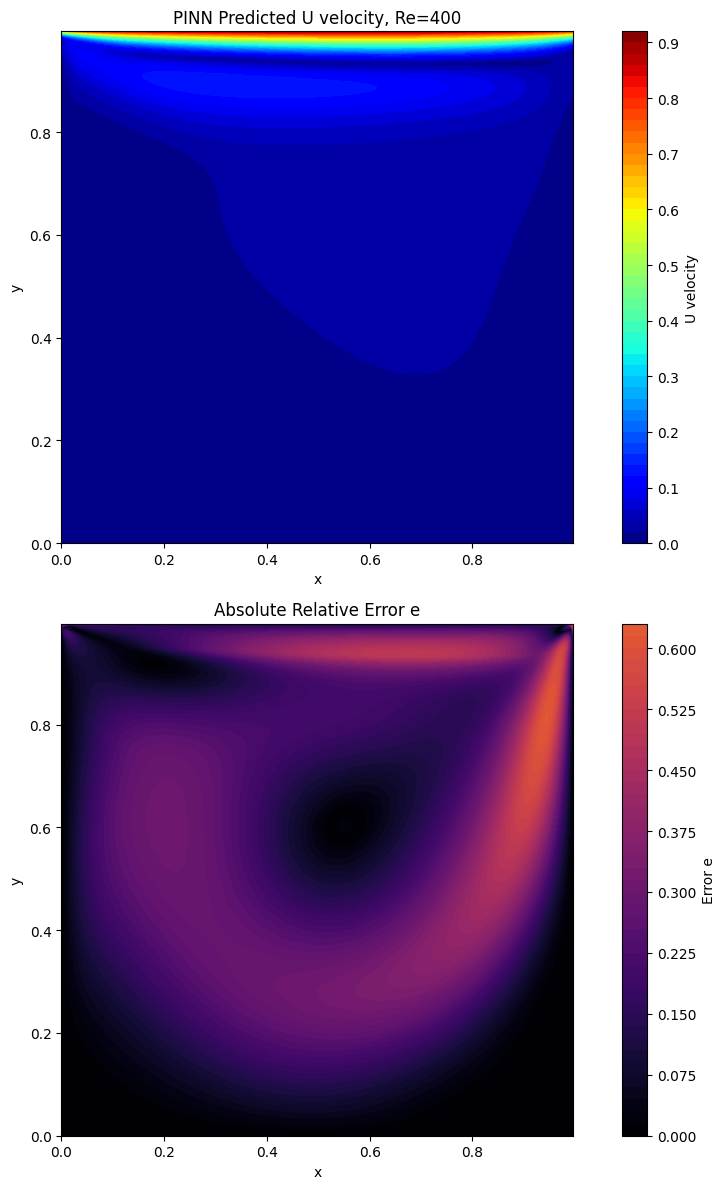

0.7963219070880326


In [ ]:
a, b = 0, 1   
c, d = 0, 1   
shape = 252  

x = np.linspace(a, b, shape, endpoint=False)
y = np.linspace(c, d, shape, endpoint=False)
X, Y = np.meshgrid(x, y)

xy_testing = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

def standardize_with_minmax(x_input, x_min, x_max):
    return 2.0 * (x_input - x_min) / (x_max - x_min) - 1.0

xy_testing_stdized = standardize_with_minmax(xy_testing, 
                                             np.min(xy_input, axis=0), 
                                             np.max(xy_input, axis=0))

U_flat = model.call(xy_testing_stdized)[:, 0].numpy()
V_flat = model.call(xy_testing_stdized)[:, 1].numpy()

U_magnitude = np.sqrt(U_flat**2 + V_flat**2)

U_grid = U_flat.reshape(X.shape)
V_grid = V_flat.reshape(X.shape)
Umagnitude_grid = U_magnitude.reshape(X.shape)
e_local = np.abs(Umagnitude_grid - UVmag_true) 
e_grid = e_local.reshape(X.shape) 

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

c1 = ax[0].contourf(X, Y, Umagnitude_grid, levels=50, cmap="jet")
fig.colorbar(c1, ax=ax[0], label="U velocity")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title(f"PINN Predicted U velocity, Re={Re}")
ax[0].set_aspect("equal")

c2 = ax[1].contourf(
    X, Y, e_grid,
    levels=50,
    cmap="inferno")

fig.colorbar(c2, ax=ax[1], label="Error e")

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Absolute Relative Error e")
ax[1].set_aspect("equal")

plt.tight_layout()
plt.show()

fig.savefig(f'savedata {Re}/PINN pred Re {Re}')

e_norm = np.sqrt(np.sum((UVmag_true - Umagnitude_grid)**2))/np.sqrt(np.sum(UVmag_true**2))
print(e_norm)

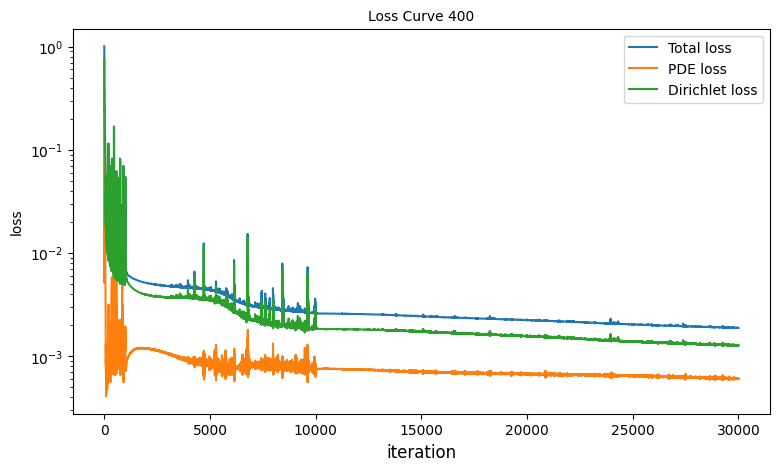

In [7]:
fig, ax = plt.subplots(figsize=(9,5))

ax.plot(history['total'], label='Total loss')
ax.plot(history['pde'], label='PDE loss')
ax.plot(history['dirichlet'], label='Dirichlet loss')
#ax.plot(history['neumann'], label='Neumann loss')

ax.set_xlabel('iteration', fontsize=12)
ax.set_ylabel('loss', fontsize=10)
ax.set_title(f"Loss Curve {Re}", fontsize=10)

# Set y-axis to log scale
ax.set_yscale('log')

# Place legend
ax.legend()

plt.show()